## Datasets loading

In [ ]:
!pip install plotly==5.10 # hack to visualize the interactive gene scanner (https://stackoverflow.com/questions/76593068/plotly-figure-not-rendering-in-ipywidgets-interact-function-google-colab)

In [3]:
# Import necessary libraries
import os
import gdown
import pandas as pd
import requests

# Function to download files from Google Drive
def download_from_google_drive(url, output_path):
    if not os.path.exists(output_path):
        file_id = url.split('/d/')[1].split('/')[0]
        gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
        print(f"Downloaded: {output_path}")
    else:
        print(f"File already exists: {output_path}")

# Function to download files
def download_file(url, output_path):
    if not os.path.exists(output_path):
        print(f"Downloading from {url}...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded: {output_path}")
        else:
            print(f"Failed to download file from {url}. HTTP Status: {response.status_code}")
    else:
        print(f"File already exists: {output_path}")


# File paths
os.makedirs("model", exist_ok=True)
os.makedirs("data", exist_ok=True)
model_path = "model/PrimaryDiseaseDetectorModel.keras"

# URLs for pretrained model and datasets
model_url = "https://raw.githubusercontent.com/lusob/PrimaryDiseaseDetector/refs/heads/main/model/PrimaryDiseaseDetectorModel.keras"
tcga_dataset_log2_url = "https://drive.google.com/file/d/1-6OA1Q0TqFeooVHmURcZ_F9YjRh9D2cK/view?usp=drive_link"
met500_dataset_log2_url = "https://drive.google.com/file/d/1nBzGFuq-ExWw0KC0dtagJqAOFjji8bQc/view?usp=drive_link"
phenotype_tcga_url = "https://drive.google.com/file/d/1wNXgjZMQUDqNosG_q8qZNIIq0za-ghF0/view?usp=drive_link"
phenotype_met500_url = "https://drive.google.com/file/d/1-7yVlLwIo2aD_eojIysUllnRXb3j-b7e/view?usp=drive_link"

# Paths for local storage
os.makedirs("model", exist_ok=True)
os.makedirs("data", exist_ok=True)
tcga_path = "data/tcga_gene_expression_log2_common_genes.csv"
met500_path = "data/met500_gene_expression_common_genes.csv"
phenotype_tcga_path = "data/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
phenotype_met500_path = "data/MET500_metadata.txt"

# Download datasets if they do not exist
print("Checking and downloading datasets if needed...")
download_file(model_url, model_path)
download_from_google_drive(tcga_dataset_log2_url, tcga_path)
download_from_google_drive(met500_dataset_log2_url, met500_path)
download_from_google_drive(phenotype_tcga_url, phenotype_tcga_path)
download_from_google_drive(phenotype_met500_url, phenotype_met500_path)

# Load datasets
print("Loading datasets...")
tcga_df_log2 = pd.read_csv(tcga_path, index_col=0)
met500_df = pd.read_csv(met500_path, index_col=0)
phenotype_tcga = pd.read_csv(phenotype_tcga_path, sep="\t").set_index("sample")
phenotype_met500 = pd.read_csv(phenotype_met500_path, sep="\t").set_index("Sample_id")

print(f"TCGA shape: {tcga_df_log2.shape}")
print(f"MET500 shape: {met500_df.shape}")
print(f"TCGA phenotypes shape: {phenotype_tcga.shape}")
print(f"MET500 phenotypes shape: {phenotype_met500.shape}")

Checking and downloading datasets if needed...
File already exists: model/PrimaryDiseaseDetectorModel.keras
File already exists: data/tcga_gene_expression_log2_common_genes.csv
File already exists: data/met500_gene_expression_common_genes.csv
File already exists: data/TCGA_phenotype_denseDataOnlyDownload.tsv.gz
File already exists: data/MET500_metadata.txt
Loading datasets...
TCGA shape: (19063, 10535)
MET500 shape: (19063, 868)
TCGA phenotypes shape: (12804, 3)
MET500 phenotypes shape: (868, 10)


## Model training and prediction

This cell is the core of the `PrimaryDiseaseDetector` notebook, responsible for both training a new model and running predictions using an existing pretrained model. It is designed to be flexible, allowing the user to toggle between these two modes depending on the value of the `RETRAIN_MODEL` variable.

### Key Features:
1. **Configurable Modes**:
   - **Training Mode (`RETRAIN_MODEL=True`)**:
     - Downloads the required datasets and preprocesses them if they are not already available.
     - Trains a Convolutional Neural Network (CNN) model on the TCGA dataset.
     - Saves the trained model to the `model/` directory for future use.
   - **Prediction Mode (`RETRAIN_MODEL=False`)**:
     - Loads a pretrained model from the `model/` directory.
     - Skips training and directly evaluates the model on the MET500 dataset.

2. **Training Workflow**:
   - **Preprocessing**: Converts gene expression data into image-like inputs suitable for CNNs.
   - **Model Architecture**:
     - Input Layer: Accepts the reshaped gene expression images.
     - Convolutional Layers: Extract patterns and features from the images.
     - Dense Layers: Perform classification tasks.
   - **Callbacks**:
     - Early stopping to avoid overfitting.
     - Learning rate reduction for better convergence.
   - **Output**: Saves the trained model as `PrimaryDiseaseDetectorModel.keras`.

3. **Evaluation Workflow**:
   - Loads and preprocesses the MET500 dataset for testing.
   - Uses the pretrained model to predict the primary disease for each sample in MET500.
   - Computes metrics such as accuracy, classification reports, and confusion matrices.

4. **Metrics and Results**:
   - Provides detailed evaluation metrics for model performance, including:
     - Accuracy: Overall prediction accuracy.
     - Classification Report: Precision, recall, and F1 scores for each class.
     - Confusion Matrix: Visual representation of prediction errors and successes.

### How to Use:
1. Set the value of `RETRAIN_MODEL`:
   - `True` to train a new model.
   - `False` to load and evaluate using an existing pretrained model.
2. Run the cell to execute the selected workflow.
3. View and interpret the training or evaluation results displayed at the end of the cell.

### Use Cases:
- **Model Development**: Train a custom CNN for disease classification.
- **Evaluation**: Assess the performance of the model on a biologically relevant test set (MET500).
- **Exploration**: Analyze model predictions to refine understanding of gene expression patterns and disease biology.

The Prediction/Training Cell is a pivotal component of the notebook, seamlessly bridging data preprocessing, model training, and real-world evaluation.

<ipython-input-4-8c29f70e396e>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_tcga['mapped_label'] = phenotype_tcga['mapped_category'].map(label_mapping)
<ipython-input-4-8c29f70e396e>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_met500['mapped_label'] = phenotype_met500['mapped_category'].map(label_mapping)


NaN values in TCGA before: 0
NaN values in TCGA after: 0
Model loaded from: model/PrimaryDiseaseDetectorModel.keras
NaN values in MET500 before: 0
NaN values in MET500 after: 0
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Test Accuracy: 0.8035

Classification Report:
                   precision    recall  f1-score   support

   Bladder Cancer       0.58      0.70      0.64        30
     Brain Cancer       1.00      0.85      0.92        13
    Breast Cancer       0.96      0.92      0.94       159
Colorectal Cancer       0.75      0.75      0.75        20
    Kidney Cancer       0.55      0.92      0.69        12
      Lung Cancer       0.48      0.88      0.62        42
  Prostate Cancer       1.00      0.74      0.85       155
          Sarcoma       0.87      0.79      0.83       100
      Skin Cancer       0.50      0.59      0.54        44

         accuracy                           0.80       575
        macro avg       0.74      0.79      0.75       575
     weighted avg       0.8

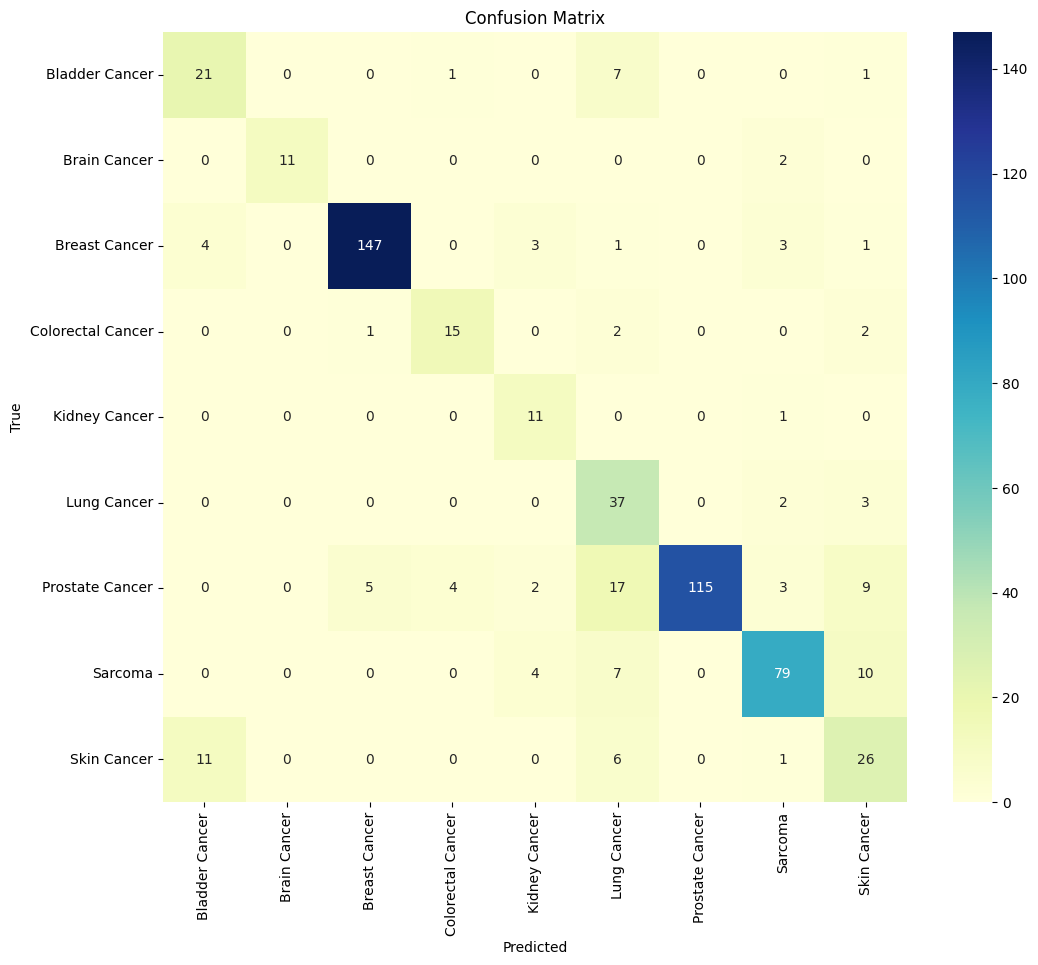

In [4]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
RETRAIN_MODEL = False  # Set to True to train a new model
model_file = "model/PrimaryDiseaseDetectorModel.keras"

# Ensure directories exist
os.makedirs("data", exist_ok=True)
os.makedirs("model", exist_ok=True)

# Category mapping
category_mapping = {
    'breast': 'Breast Cancer', 'breast invasive carcinoma': 'Breast Cancer',
    'colon': 'Colorectal Cancer', 'colon adenocarcinoma': 'Colorectal Cancer', 'rectum adenocarcinoma': 'Colorectal Cancer',
    'skin': 'Skin Cancer', 'skin cutaneous melanoma': 'Skin Cancer', 'uveal melanoma': 'Skin Cancer',
    'sarcomatoid': 'Sarcoma', 'sarcoma': 'Sarcoma',
    'gall_bladder': 'Gallbladder/Biliary Cancer', 'cholangiocarcinoma': 'Gallbladder/Biliary Cancer',
    'prostate': 'Prostate Cancer', 'prostate adenocarcinoma': 'Prostate Cancer',
    'bladder': 'Bladder Cancer', 'bladder urothelial carcinoma': 'Bladder Cancer',
    'adrenal': 'Adrenal Cancer', 'adrenocortical cancer': 'Adrenal Cancer',
    'lung': 'Lung Cancer', 'lung adenocarcinoma': 'Lung Cancer', 'lung squamous cell carcinoma': 'Lung Cancer',
    'brain': 'Brain Cancer', 'glioblastoma multiforme': 'Brain Cancer', 'brain lower grade glioma': 'Brain Cancer',
    'kidney': 'Kidney Cancer', 'kidney papillary cell carcinoma': 'Kidney Cancer',
    'kidney clear cell carcinoma': 'Kidney Cancer', 'kidney chromophobe': 'Kidney Cancer',
}

# Synchronize indices and filter data
phenotype_tcga['mapped_category'] = phenotype_tcga['_primary_disease'].map(category_mapping)
phenotype_met500['mapped_category'] = phenotype_met500['tissue'].map(category_mapping)

# Filter out residual or invalid categories
classes_to_exclude = {'Other', 'Adrenal Cancer', 'Gallbladder/Biliary Cancer'}
phenotype_tcga = phenotype_tcga[~phenotype_tcga['mapped_category'].isin(classes_to_exclude)]
phenotype_met500 = phenotype_met500[~phenotype_met500['mapped_category'].isin(classes_to_exclude)]

# Map categories to labels
common_categories = sorted(phenotype_tcga['mapped_category'].dropna().unique())
label_mapping = {category: idx for idx, category in enumerate(common_categories)}

# Apply label mapping
phenotype_tcga['mapped_label'] = phenotype_tcga['mapped_category'].map(label_mapping)
phenotype_met500['mapped_label'] = phenotype_met500['mapped_category'].map(label_mapping)

# Ensure data consistency for TCGA
phenotype_indices_tcga = phenotype_tcga.index.intersection(tcga_df_log2.columns)
phenotype_tcga_filtered = phenotype_tcga.loc[phenotype_indices_tcga]
tcga_df_log2_filtered = tcga_df_log2[phenotype_indices_tcga]

# Handle NaN values in TCGA data
print("NaN values in TCGA before:", tcga_df_log2_filtered.isnull().sum().sum())
tcga_df_log2_filtered = tcga_df_log2_filtered.loc[tcga_df_log2_filtered.isna().mean(axis=1) <= 0.8].T
tcga_df_log2_filtered = tcga_df_log2_filtered.apply(lambda x: x.fillna(x.mean()), axis=0)
print("NaN values in TCGA after:", tcga_df_log2_filtered.isnull().sum().sum())

# Filter valid indices
valid_indices_tcga = phenotype_tcga_filtered['mapped_label'].notna()
phenotype_tcga_filtered = phenotype_tcga_filtered.loc[valid_indices_tcga]
tcga_df_log2_filtered = tcga_df_log2_filtered.loc[phenotype_tcga_filtered.index]

# Scale and prepare TCGA data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(tcga_df_log2_filtered)
y_train = phenotype_tcga_filtered['mapped_label'].astype(int).values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data into image format
num_genes = X_train.shape[1]
image_size = int(np.ceil(np.sqrt(num_genes)))
padding = image_size**2 - num_genes

X_train_images = np.array([
    np.pad(sample, (0, padding), mode='constant').reshape(image_size, image_size)
    for sample in X_train
])
X_val_images = np.array([
    np.pad(sample, (0, padding), mode='constant').reshape(image_size, image_size)
    for sample in X_val
])

X_train_images = X_train_images[..., np.newaxis]
X_val_images = X_val_images[..., np.newaxis]

# Train the model
if RETRAIN_MODEL:
    input_layer = Input(shape=(image_size, image_size, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', strides=(5, 5))(input_layer)
    flatten = Flatten()(conv1)
    dropout = Dropout(0.5)(flatten)
    output_layer = Dense(len(common_categories), activation='softmax')(dropout)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

    history = model.fit(
        X_train_images, y_train,
        validation_data=(X_val_images, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    model.save(model_file)
    print(f"Model saved to: {model_file}")
else:
    model = load_model(model_file)
    print(f"Model loaded from: {model_file}")

# Prepare MET500 data
phenotype_indices_met500 = phenotype_met500.index.intersection(met500_df.columns)
phenotype_met500_filtered = phenotype_met500.loc[phenotype_indices_met500]
met500_df_filtered = met500_df[phenotype_indices_met500]

# Handle NaN values in MET500 data
print("NaN values in MET500 before:", met500_df_filtered.isnull().sum().sum())
met500_df_filtered = met500_df_filtered.loc[met500_df_filtered.isna().mean(axis=1) <= 0.8].T
met500_df_filtered = met500_df_filtered.apply(lambda x: x.fillna(x.mean()), axis=0)
print("NaN values in MET500 after:", met500_df_filtered.isnull().sum().sum())

# Filter valid indices
valid_indices_met500 = phenotype_met500_filtered['mapped_label'].notna()
phenotype_met500_filtered = phenotype_met500_filtered.loc[valid_indices_met500]
met500_df_filtered = met500_df_filtered.loc[phenotype_met500_filtered.index]

# Scale and prepare MET500 data
X_test = scaler.fit_transform(met500_df_filtered)
y_test = phenotype_met500_filtered['mapped_label'].astype(int).values

X_test_images = np.array([
    np.pad(sample, (0, padding), mode='constant').reshape(image_size, image_size)
    for sample in X_test
])
X_test_images = X_test_images[..., np.newaxis]

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_images), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=common_categories))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=common_categories, yticklabels=common_categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Model evaluation

### Evaluation of the MET500 Test Set with Thresholds and 'UNKNOWN' Category

This cell evaluates the predictions of the pretrained model on the MET500 test set, introducing the concept of an 'UNKNOWN' category to account for cases where the model's confidence is below a specified threshold.

#### Key Features:
1. **Dynamic Threshold Adjustment**:
   - A confidence threshold (default: `0.8`) is applied to the prediction scores.
   - Predictions with scores below the threshold are categorized as 'UNKNOWN', representing cases where the model is uncertain about the primary disease.

2. **Extension of Categories**:
   - The list of known categories (`common_categories`) is dynamically extended to include 'UNKNOWN' as an additional category.

3. **Adjusted Evaluation**:
   - Predictions are recalibrated based on the confidence threshold.
   - An adjusted classification report and confusion matrix are generated, incorporating the 'UNKNOWN' category.

4. **Visualization**:
   - An updated confusion matrix heatmap is displayed, showing the distribution of predictions across known categories and the 'UNKNOWN' category.

#### Use Cases:
- **Improved Interpretability**:
  - By introducing an 'UNKNOWN' category, the model explicitly identifies cases where its confidence is low, reducing the risk of misclassification.
- **Clinical Relevance**:
  - The 'UNKNOWN' category can help flag ambiguous cases for further investigation, improving the model's reliability in real-world scenarios.

#### Results:
The cell outputs:
- An adjusted classification report with precision, recall, and F1-scores for all categories, including 'UNKNOWN'.
- A confusion matrix heatmap that visualizes the model's performance, highlighting cases where predictions fall below the confidence threshold.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Adjusted Classification Report (including UNKNOWN):
                   precision    recall  f1-score   support

   Bladder Cancer       0.84      0.53      0.65        30
     Brain Cancer       1.00      0.85      0.92        13
    Breast Cancer       1.00      0.87      0.93       159
Colorectal Cancer       0.93      0.70      0.80        20
    Kidney Cancer       0.67      0.83      0.74        12
      Lung Cancer       0.66      0.83      0.74        42
  Prostate Cancer       1.00      0.54      0.70       155
          Sarcoma       0.93      0.69      0.79       100
      Skin Cancer       0.82      0.52      0.64        44
          UNKNOWN       0.00      0.00      0.00         0

         accuracy                           0.70       575
        macro avg       0.79      0.64      0.69       575
     weighted avg       0.93      0.70      0.79       575



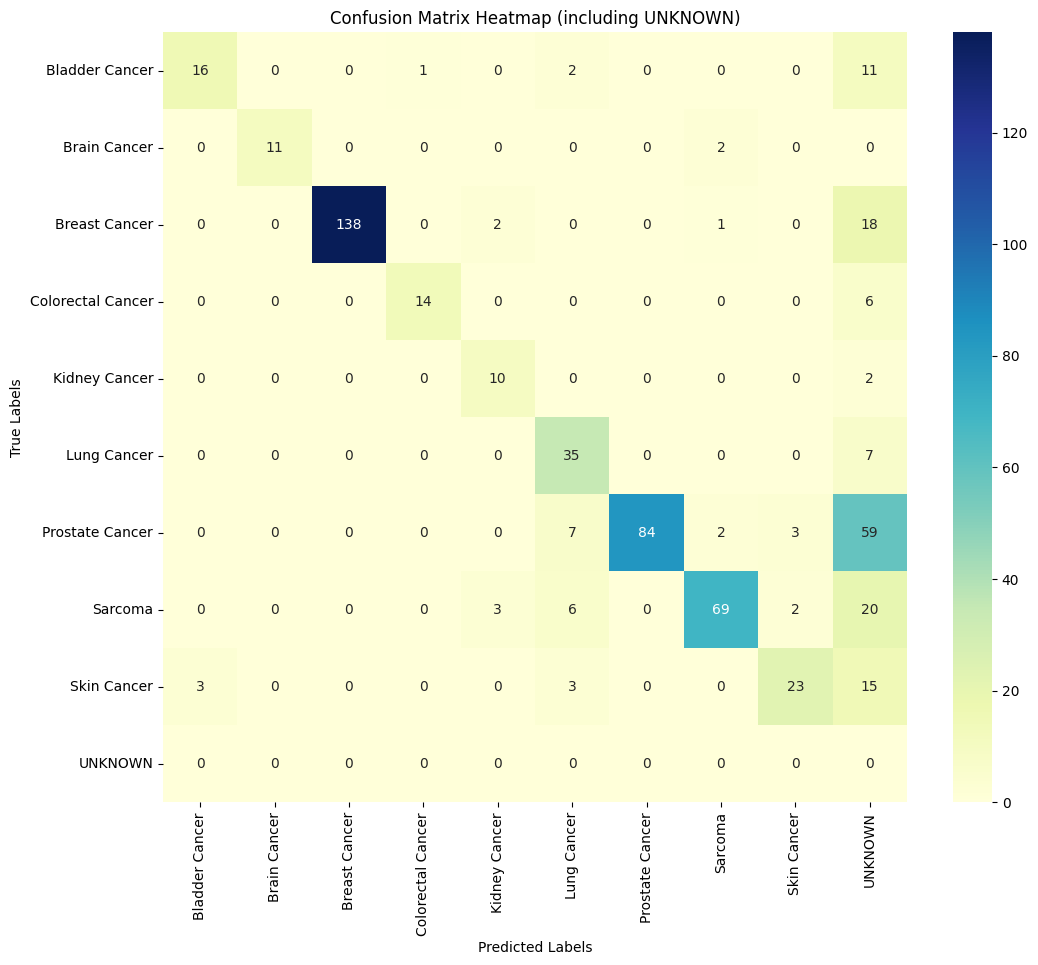

In [5]:
# Evaluation of the MET500 test set with thresholds and 'UNKNOWN' category

from sklearn.utils.multiclass import unique_labels

# If the prediction score is below this threshold, the prediction is considered UNKNOWN
confidence_threshold = 0.8

# Ensure that "UNKNOWN" is included in common_categories
if "UNKNOWN" not in common_categories:
    common_categories.append("UNKNOWN")

# Compute prediction scores for the test set
y_pred_scores = model.predict(X_test_images)

# Adjust predictions based on dynamic thresholds
adjusted_preds = []
for i, scores in enumerate(y_pred_scores):
    max_score = np.max(scores)
    predicted_category = common_categories[np.argmax(scores)]
    if max_score >= confidence_threshold:  # Threshold for known categories
        adjusted_preds.append(np.argmax(scores))
    else:
        adjusted_preds.append(len(common_categories) - 1)  # Index of "UNKNOWN"

# Extend the test labels to include UNKNOWN
y_test_extended = np.append(y_test, len(common_categories) - 1)

# Generate the adjusted classification report
print("\nAdjusted Classification Report (including UNKNOWN):")
print(classification_report(
    y_test,
    adjusted_preds,
    target_names=common_categories,
    zero_division=0
))

# Generate the adjusted confusion matrix
conf_matrix = confusion_matrix(y_test, adjusted_preds, labels=range(len(common_categories)))

# Visualize the adjusted confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=common_categories, yticklabels=common_categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap (including UNKNOWN)")
plt.show()

### Model Evaluation on CUPS Test Set

This cell evaluates the model using a subset of the MET500 dataset, filtering samples where `biopsy_tissue` differs from `tissue`. This represents a potential scenario for cancer of unknown primary (CUPS) cases.

#### Steps:
1. **Filter the CUPS Test Set**:
   - Select samples where the biopsy tissue (`biopsy_tissue`) does not match the expected tissue (`tissue`).

2. **Data Preparation**:
   - Features are scaled and transformed into images compatible with the model.

3. **Model Evaluation**:
   - Predictions are generated for these samples, and accuracy is calculated.

4. **Reporting and Visualization**:
   - A classification report is displayed.
   - A confusion matrix is visualized as a heatmap.

#### Expected Results:
- Metrics that reflect the model's performance on this specialized subset of data.
- Detailed analysis comparing predictions to actual labels.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Accuracy on MET500 CUPS Test Set (biopsy_tissue != tissue): 0.7955

Classification Report for MET500 CUPS Test Set (biopsy_tissue != tissue):
                   precision    recall  f1-score   support

   Bladder Cancer       0.56      0.64      0.60        28
    Breast Cancer       0.96      0.93      0.94       157
Colorectal Cancer       0.72      0.72      0.72        18
    Kidney Cancer       0.52      0.92      0.67        12
      Lung Cancer       0.46      0.87      0.61        38
  Prostate Cancer       1.00      0.74      0.85       153
          Sarcoma       0.89      0.79      0.84       100
      Skin Cancer       0.36      0.47      0.41        32

         accuracy                           0.80       538
        macro avg       0.68      0.76      0.70       538
     weighted avg       0.85      0.80      0.81       538



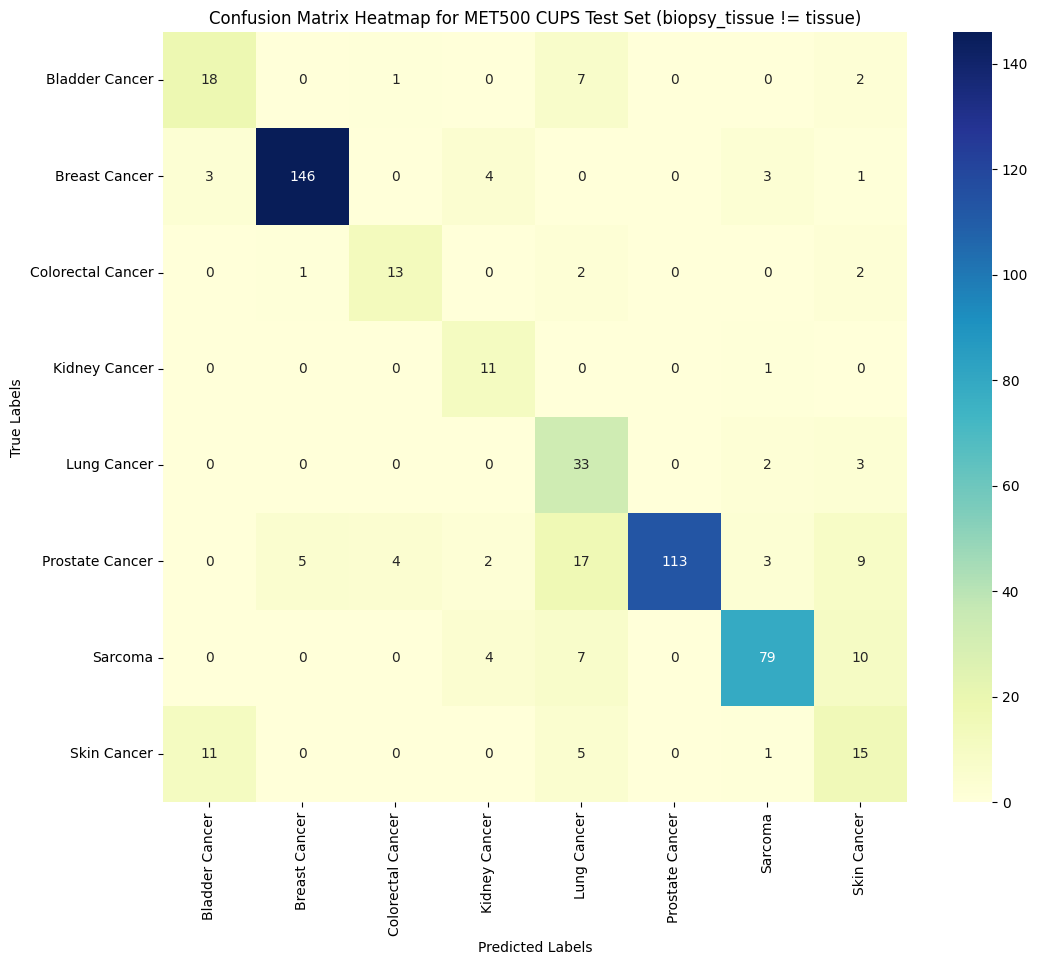

In [6]:
# CUPS Test Set Evaluation (Samples where 'biopsy_tissue' != 'tissue')

# Filter CUPS Test Set: 'biopsy_tissue' != 'tissue'
cups_test_set = phenotype_met500_filtered[phenotype_met500_filtered['biopsy_tissue'] != phenotype_met500_filtered['tissue']]

# Filter expression data corresponding to CUPS Test Set
aligned_indices_cups = cups_test_set.index.intersection(met500_df_filtered.index)
cups_test_set = cups_test_set.loc[aligned_indices_cups]
cups_met500_df = met500_df_filtered.loc[aligned_indices_cups]

# Prepare features and labels for CUPS Test Set
X_cups_met500 = scaler.fit_transform(cups_met500_df)
y_cups_met500 = cups_test_set['mapped_label'].astype(int).values

# Convert CUPS Test Set data into image format
X_cups_images = np.array([
    np.pad(sample, (0, padding), mode='constant').reshape(image_size, image_size)
    for sample in X_cups_met500
])
X_cups_images = X_cups_images[..., np.newaxis]

# Ensure dimensions are consistent
assert X_cups_images.shape[0] == len(y_cups_met500), "Inconsistency between X_cups_images and y_cups_met500"

# Evaluate the model on the CUPS Test Set
y_pred_cups = np.argmax(model.predict(X_cups_images), axis=1)

# Calculate accuracy on the CUPS Test Set
cups_accuracy = accuracy_score(y_cups_met500, y_pred_cups)
print(f"\nAccuracy on MET500 CUPS Test Set (biopsy_tissue != tissue): {cups_accuracy:.4f}")

from sklearn.utils.multiclass import unique_labels

# Determine unique classes in the test set
unique_classes_cups = unique_labels(y_cups_met500, y_pred_cups)

# Generate the classification report
print("\nClassification Report for MET500 CUPS Test Set (biopsy_tissue != tissue):")
print(classification_report(
    y_cups_met500,
    y_pred_cups,
    target_names=[common_categories[i] for i in unique_classes_cups]
))

# Generate the confusion matrix
cups_conf_matrix = confusion_matrix(y_cups_met500, y_pred_cups, labels=unique_classes_cups)

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cups_conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=[common_categories[i] for i in unique_classes_cups],
            yticklabels=[common_categories[i] for i in unique_classes_cups])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap for MET500 CUPS Test Set (biopsy_tissue != tissue)")
plt.show()

## GeneScanner: Visualization Tool for Model Interpretability

The following cell is an interactive tool that allows users to interpret model predictions by visualizing the most influential genes for a given sample. The tool leverages the Grad-CAM (Gradient-weighted Class Activation Mapping) technique to generate heatmaps superimposed on the input image, which represents gene expression data.

### Key Features:
- **Interactive Sample Selection**: Users can search and select specific samples from the MET500 dataset using an intuitive widget-based interface.
- **Individual Prediction Insights**: Unlike traditional feature importance techniques that provide a global view, GeneScanner generates heatmaps tailored to each individual sample, highlighting the specific combination of genes that influenced the model’s prediction.
- **Detailed Visualization**:
  - Displays the original input image (gene expression matrix as an image).
  - Generates a gradient-based heatmap to show activation levels of the most relevant genes.
  - Superimposes the heatmap on the input image for an intuitive visual representation.
- **Supports Clinical Applications**: By pinpointing the most influential genes for each prediction, GeneScanner aids in understanding the underlying biology and can potentially guide personalized treatment strategies.

### How It Works:
1. **Search and Select a Sample**: Use the provided search box or dropdown menu to locate a sample ID from the MET500 dataset.
2. **Generate a Heatmap**: Click the "Generate Heatmap" button to visualize:
   - The original gene expression input image.
   - The Grad-CAM heatmap highlighting important genes.
   - A combined visualization with the heatmap superimposed on the input image.
3. **Interpret the Results**:
   - The tool displays the predicted disease, the true disease label, and the activation heatmap.
   - This enables users to investigate the model's reasoning for its prediction.

### Potential Use Cases:
- **Cancer of Unknown Primary (CUP)**: Identify the genes contributing to the model’s classification of primary disease.
- **General Tumor Classification**: Explore key genes driving predictions for various tumor types.
- **Research and Clinical Applications**: Gain insights into tumor biology and support personalized treatment strategies by identifying patient-specific gene activation patterns.


In [46]:
# GeneScanner: Interactive Visualization Tool

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output
import tensorflow as tf
import plotly.express as px

# Verify required variables are initialized
required_vars = ['model', 'X_test_images', 'y_test', 'label_mapping', 'phenotype_met500_filtered']

if not all(var in globals() for var in required_vars):
    print("❌ Missing required variables.")
    print("Ensure the training cell has been executed before run this cell to initialize the following variables:")
    for var in required_vars:
        if var not in globals():
            print(f" - {var}")
else:
    label_dict_met500 = {v: k for k, v in label_mapping.items()}
    met500_ids_filtered = phenotype_met500_filtered.index.tolist()

    # Grad-CAM function
    def get_grad_cam(model, img_array, last_conv_layer_name, label_dict, class_index=None):
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

        result = model(img_array, training=False)
        predicted_class = np.argmax(result[0]) if class_index is None else class_index
        predicted_score = result[0][predicted_class]
        predicted_disease = label_dict[predicted_class]

        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            tape.watch(img_array)
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, predicted_class]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0].numpy()
        pooled_grads = pooled_grads.numpy()

        for i in range(conv_outputs.shape[-1]):
            conv_outputs[:, :, i] *= pooled_grads[i]

        heatmap = np.mean(conv_outputs, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

        return heatmap, predicted_disease, predicted_score

    # Overlay heatmap function
    def overlay_rescaled_heatmap(heatmap, img, alpha=0.8, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = 1 - heatmap  # Invierte valores de activación
        heatmap = np.uint8(255 * heatmap)
        heatmap_colored = cv2.applyColorMap(heatmap, colormap)
        img = np.uint8(255 * img)
        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        superimposed_img = cv2.addWeighted(heatmap_colored, alpha, img, 1 - alpha, 0)
        return superimposed_img

    # Interactive visualization
    output_image = widgets.Output()

    def display_results(met500_id):
        if met500_id == 'No results found':
            print("No results found. Please select a valid option.")
            return

        with output_image:
            output_image.clear_output(wait=True)

            sample_index = met500_ids_filtered.index(met500_id)
            img_to_visualize = X_test_images[sample_index]
            real_label = y_test[sample_index]
            real_disease = label_dict_met500[real_label]

            last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

            heatmap, predicted_disease, predicted_score = get_grad_cam(model, img_to_visualize, last_conv_layer_name, label_dict_met500)
            superimposed_img = overlay_rescaled_heatmap(heatmap, img_to_visualize)
            image_size = superimposed_img.shape[0]

            # Create DataFrames for genes and their expression values
            gene_grid = np.empty((image_size, image_size), dtype=object)
            expression_values_grid = np.empty((image_size, image_size), dtype=float)
            activation_values_grid = superimposed_img[..., 0] / 255.0 # Normalize activation values

            gene_names = met500_df_filtered.columns
            for i in range(image_size):
                for j in range(image_size):
                    index = i * image_size + j
                    if index < len(gene_names):
                        gene_grid[i, j] = gene_names[index]
                        expression_values_grid[i, j] = met500_df_filtered.iloc[sample_index, index]
                    else:
                        gene_grid[i, j] = 'Padding'
                        expression_values_grid[i, j] = 0.0

            gene_df = pd.DataFrame(gene_grid)
            expression_df = pd.DataFrame(expression_values_grid)

            gene_scanner = px.imshow(superimposed_img,
                            labels=dict(x="Eje X (píxeles)", y="Eje Y (píxeles)"),
                            title=f"Interactive Gene Scanner\nPredicted: {predicted_disease}\nScore: {predicted_score:.2f}",
                            aspect="auto")

            # Assign genes, expression and activation values ​​to the image trace tooltips
            gene_scanner.update_traces(
                selector=dict(type='image'),
                hovertemplate="Gen: %{customdata[0]}<br>Expresión: %{customdata[1]:.4f}<br>Activación: %{customdata[2]:.4f}",
                customdata=np.dstack([gene_df.values, expression_df.values, activation_values_grid])
            )

            gene_scanner.update_layout(
                title=dict(
                    text=f"Interactive Gene Scanner<br>Predicted: {predicted_disease}<br>Score: {predicted_score:.2f}",
                    x=0.5,
                    y=0.95,
                    xanchor='center',
                    yanchor='top',
                    font=dict(size=20)
                ),
                width=1600,
                height=800
            )

            # Show first static images
            plt.figure(figsize=(15, 5))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(img_to_visualize.squeeze(), cmap='gray')
            plt.title(f"Original Image\nReal: {real_disease}", fontsize=10)
            plt.axis('off')

            # Heatmap
            plt.subplot(1, 3, 2)
            plt.imshow(heatmap, cmap='viridis')
            plt.colorbar(label='Activation (Grad-CAM)')
            plt.title(f"Heatmap", fontsize=10)
            plt.axis('off')

            # Superimposed Heatmap
            plt.subplot(1, 3, 3)
            plt.imshow(superimposed_img)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Show interactive Gene Scanner
            gene_scanner.show()

    search_box = widgets.Text(placeholder='Search MET500 ID...', description='Search:')
    select = widgets.Select(options=met500_ids_filtered, description='MET500 ID:')
    confirm_button = widgets.Button(description='Generate Heatmap', button_style='success')

    def handle_prediction(b):
        if select.value and select.value != 'No results found':
            display_results(select.value)
        else:
            print("Please select a valid ID before running the prediction.")

    confirm_button.on_click(handle_prediction)

    def filter_options(change):
        search_text = change['new']
        filtered_options = [opt for opt in met500_ids_filtered if search_text.lower() in opt.lower()]
        select.options = filtered_options if filtered_options else ['No results found']

    search_box.observe(filter_options, names='value')

    display(widgets.HBox([search_box, select, confirm_button]), output_image)

Output()

## Data Preprocessing

The Data Preprocessing Cell prepares the input data for the `PrimaryDiseaseDetector` pipeline by downloading and filtering the TCGA and MET500 datasets to include only common genes. This ensures consistency and compatibility between the datasets for training and evaluation.

### Key Features:
1. **Automatic Dataset Handling**:
   - Downloads the TCGA and MET500 datasets from their respective sources if they are not already available locally.
   - Ensures that only common genes between the datasets are retained for analysis.

2. **Filtering and Alignment**:
   - Intersects the gene lists of TCGA and MET500 to include only the genes shared by both datasets.
   - Filters the datasets to retain these common genes, ensuring a consistent feature set.

3. **Output**:
   - Saves the processed datasets as `.csv` files in the `data/` directory for future use.

### Steps in Preprocessing:
1. **Download**:
   - Retrieves the TCGA and MET500 gene expression data from public sources in compressed `.gz` format.
2. **Intersection of Genes**:
   - Identifies and retains only the genes that are present in both datasets, ensuring compatibility.
3. **Save Processed Data**:
   - Saves the filtered datasets locally in `.csv` format for efficient reuse.

### How It Works:
- If the preprocessed files are not found locally, the cell automatically downloads, processes, and saves the datasets.
- If the files already exist, the cell skips the preprocessing steps and informs the user. To reprocess the data, the existing files must be deleted manually.

### Use Cases:
- **Data Preparation for Training**: Ensures that the datasets are clean, aligned, and ready to be consumed by the CNN model.
- **Efficient Data Management**: Allows users to skip redundant preprocessing if the datasets have already been prepared, saving time and resources.
- **Reproducibility**: Guarantees a consistent set of features (common genes) across the TCGA and MET500 datasets.

The Data Preprocessing Cell is a fundamental step in aligning and structuring the raw gene expression data, ensuring the compatibility and reliability of downstream analyses in the `PrimaryDiseaseDetector` pipeline.

In [6]:
# Preprocessing Data

# Importing necessary libraries
import os
import requests
import gzip
import pandas as pd
from io import BytesIO

# URLs of the datasets
tcga_url = "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_fpkm.gz"
met500_url = "https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/MET500%2FgeneExpression%2FM.mx.log2.txt.gz"

# File paths for the processed datasets
tcga_file_path = "data/tcga_gene_expression_log2_common_genes.csv"
met500_file_path = "data/met500_gene_expression_common_genes.csv"

# Ensure the data directory exists
os.makedirs("data", exist_ok=True)

# Function to download and load the compressed file
def download_and_load_gzip(url):
    response = requests.get(url, stream=True)
    with gzip.open(BytesIO(response.content), 'rt') as f:
        df = pd.read_csv(f, sep='\t', index_col=0)
    return df

# Check if files already exist
if os.path.exists(tcga_file_path) and os.path.exists(met500_file_path):
    print(f"Processed files already exist:")
    print(f"- TCGA: {tcga_file_path}")
    print(f"- MET500: {met500_file_path}")
    print("\nIf you want to preprocess the data again, delete the existing files and re-run this cell.")
else:
    # Process the TCGA dataset
    print("Downloading and processing TCGA data...")
    tcga_df = download_and_load_gzip(tcga_url)

    # Process the MET500 dataset
    print("Downloading and processing MET500 data...")
    met500_df = download_and_load_gzip(met500_url)

    # Intersect common genes between TCGA and MET500
    common_genes = tcga_df.index.intersection(met500_df.index)

    # Filter both datasets for common genes
    tcga_df_log2 = tcga_df.loc[common_genes]
    met500_df_log2 = met500_df.loc[common_genes]

    # Check dimensions after filtering
    print(f"Number of common genes: {len(common_genes)}")
    print(f"Dimensions of TCGA dataset after filtering: {tcga_df_log2.shape}")
    print(f"Dimensions of MET500 dataset after filtering: {met500_df_log2.shape}")

    # Save the processed datasets to local files
    tcga_df_log2.to_csv(tcga_file_path)
    met500_df_log2.to_csv(met500_file_path)

    print(f"Processed TCGA dataset saved to: {tcga_file_path}")
    print(f"Processed MET500 dataset saved to: {met500_file_path}")

Processed files already exist:
- TCGA: data/tcga_gene_expression_log2_common_genes.csv
- MET500: data/met500_gene_expression_common_genes.csv

If you want to preprocess the data again, delete the existing files and re-run this cell.
